## Assignment: Predict Temperature


### 1. Predicting temperature

In this exercise, you'll work with historical temperature data from the Szeged, Hungary area. The dataset you'll use is a Postgres database version of this dataset from Kaggle. To complete this assignment, submit a Jupyter notebook containing your solutions to the following tasks:

    1. First, load the dataset from the weatherinszeged table from Thinkful's database.

    2. Build a regression model where the target variable is temperature. As explanatory variables, use humidity,         windspeed, windbearing, and pressure. Estimate the model using OLS.

    3. Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met,         discuss the implications of the violations for the correctness of your model.

Here are the credentials you can use to connect to the database:

    postgres_user = 'dsbc_student'
    postgres_pw = '7*.8G9QH21'
    postgres_host = '142.93.121.174'
    postgres_port = '5432'
    postgres_db = 'weatherinszeged'

As in earlier assignments, be sure to close the database connection after initially pulling in your data.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
import statsmodels.formula.api as smf
from sqlalchemy import create_engine
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format
import warnings
warnings.filterwarnings(action="ignore")

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'weatherinszeged'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

weather_df = pd.read_sql_query('select * from weatherinszeged',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

weather_df.head(10)

,date,summary,preciptype,temperature,apparenttemperature,humidity,windspeed,windbearing,visibility,loudcover,pressure,dailysummary
0,2006-03-31 22:00:00+00:00,Partly Cloudy,rain,9.472,7.389,0.890,14.120,251.000,15.826,0.000,1015.130,Partly cloudy throughout the day.
1,2006-03-31 23:00:00+00:00,Partly Cloudy,rain,9.356,7.228,0.860,14.265,259.000,15.826,0.000,1015.630,Partly cloudy throughout the day.
2,2006-04-01 00:00:00+00:00,Mostly Cloudy,rain,9.378,9.378,0.890,3.928,204.000,14.957,0.000,1015.940,Partly cloudy throughout the day.
3,2006-04-01 01:00:00+00:00,Partly Cloudy,rain,8.289,5.944,0.830,14.104,269.000,15.826,0.000,1016.410,Partly cloudy throughout the day.
4,2006-04-01 02:00:00+00:00,Mostly Cloudy,rain,8.756,6.978,0.830,11.045,259.000,15.826,0.000,1016.510,Partly cloudy throughout the day.
5,2006-04-01 03:00:00+00:00,Partly Cloudy,rain,9.222,7.111,0.850,13.959,258.000,14.957,0.000,1016.660,Partly cloudy throughout the day.
6,2006-04-01 04:00:00+00:00,Partly Cloudy,rain,7.733,5.522,0.950,12.365,259.000,9.982,0.000,1016.720,Partly cloudy throughout the day.
7,2006-04-01 05:00:00+00:00,Partly Cloudy,rain,8.772,6.528,0.890,14.152,260.000,9.982,0.000,1016.840,Partly cloudy throughout the day.
8,2006-04-01 06:00:00+00:00,Partly Cloudy,rain,10.822,10.822,0.820,11.318,259.000,9.982,0.000,1017.370,Partly cloudy throughout the day.
9,2006-04-01 07:00:00+00:00,Partly Cloudy,rain,13.772,13.772,0.720,12.526,279.000,9.982,0.000,1017.220,Partly cloudy throughout the day.


### 1) Explore and clean the data

In [2]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 12 columns):
date                   96453 non-null datetime64[ns, UTC]
summary                96453 non-null object
preciptype             96453 non-null object
temperature            96453 non-null float64
apparenttemperature    96453 non-null float64
humidity               96453 non-null float64
windspeed              96453 non-null float64
windbearing            96453 non-null float64
visibility             96453 non-null float64
loudcover              96453 non-null float64
pressure               96453 non-null float64
dailysummary           96453 non-null object
dtypes: datetime64[ns, UTC](1), float64(8), object(3)
memory usage: 8.8+ MB


In [3]:
#Checked for NaN values and didn't find any.  The describe function shows that there may not be appearance of outliers
#Drop columns we will not use
weather_df.drop(columns=['date', 'summary','preciptype','dailysummary','apparenttemperature','visibility','loudcover'], axis=1, inplace=True)
weather_df.describe()

,temperature,humidity,windspeed,windbearing,pressure
count,96453.000,96453.000,96453.000,96453.000,96453.000
mean,11.933,0.735,10.811,187.509,1003.236
std,9.552,0.195,6.914,107.383,116.970
min,-21.822,0.000,0.000,0.000,0.000
25%,4.689,0.600,5.828,116.000,1011.900
50%,12.000,0.780,9.966,180.000,1016.450
75%,18.839,0.890,14.136,290.000,1021.090
max,39.906,1.000,63.853,359.000,1046.380


In [23]:
#Handle outliers

import scipy.stats as stats
from scipy.stats.mstats import winsorize

def using_mstats(s):
    return winsorize(s, limits=[0.05, 0.05])

weather_clean = weather_df.apply(using_mstats, axis=0)
weather_clean.quantile([0, 0.05, 0.25, 0.5, 0.75, 0.95, 1])

,temperature,humidity,windspeed,windbearing,pressure
0.000,-2.767,0.350,2.528,10.000,1003.200
0.050,-2.767,0.350,2.528,10.000,1003.200
0.250,4.689,0.600,5.828,116.000,1011.900
0.500,12.000,0.780,9.966,180.000,1016.450
0.750,18.839,0.890,14.136,290.000,1021.090
0.950,27.778,0.970,24.430,341.000,1030.190
1.000,27.778,0.970,24.440,341.000,1030.190


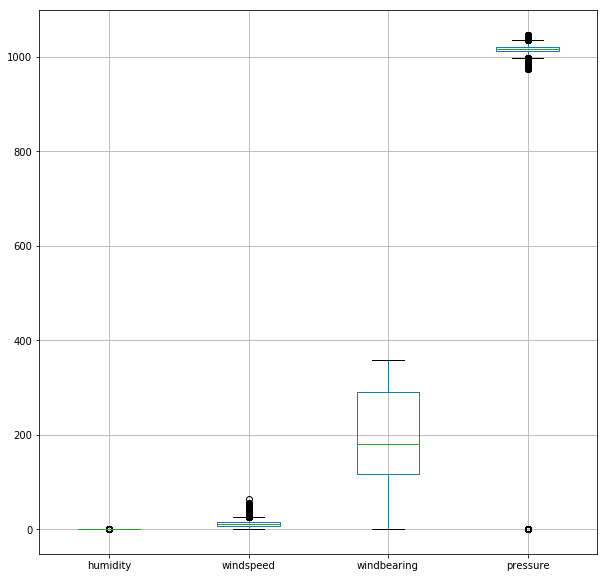

In [24]:
#Visual check for outliers on the key features for model

plt.figure(figsize=(10,10))

boxplot=weather_df.boxplot(column=['humidity', 'windspeed', 'windbearing', 'pressure'])

### 2) Build a regression model where the target variable is temperature. As explanatory variables, use humidity,         windspeed, windbearing, and pressure. Estimate the model using OLS.


In [25]:
weather_clean.head(10).T

,0,1,2,3,4,5,6,7,8,9
temperature,9.472,9.356,9.378,8.289,8.756,9.222,7.733,8.772,10.822,13.772
humidity,0.890,0.860,0.890,0.830,0.830,0.850,0.950,0.890,0.820,0.720
windspeed,14.120,14.265,3.928,14.104,11.045,13.959,12.365,14.152,11.318,12.526
windbearing,251.000,259.000,204.000,269.000,259.000,258.000,259.000,260.000,259.000,279.000
pressure,1015.130,1015.630,1015.940,1016.410,1016.510,1016.660,1016.720,1016.840,1017.370,1017.220


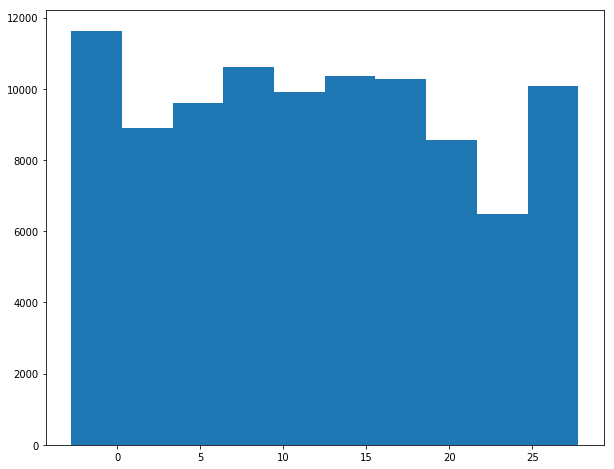

In [26]:
#Check distribution of target variable 'temperature'

plt.figure(figsize=(10,8))

#weather_clean['temperature'].plot.barh(alpha=0.5)

plt.hist(weather_clean['temperature'])
plt.show()

In [27]:
#Build the linear regression model
import statsmodels.api as sm

# Y is the target variable
Y = weather_clean['temperature']
# X is the feature set: 'humidity', 'windspeed', 'windbearing', 'pressure'
X = weather_clean[['humidity', 'windspeed', 'windbearing', 'pressure']]


# We need to manually add a constant in statsmodels' sm
X = sm.add_constant(X)

results = sm.OLS(Y, X).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            temperature   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.519
Method:                 Least Squares   F-statistic:                 2.601e+04
Date:                Fri, 30 Aug 2019   Prob (F-statistic):               0.00
Time:                        15:20:01   Log-Likelihood:            -3.1294e+05
No. Observations:               96453   AIC:                         6.259e+05
Df Residuals:                   96448   BIC:                         6.259e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         459.0986      3.008    152.629      0.000     453.203     464.994
humidity      -31.9400      0.109   -292.252      0.000     -32.154     -31.726
windspeed      -0.3312      0.003    -95.650      0.000      -0.338      -0.324
windbearing     0.0019      0.000     10.239      0.000       0.002       0.002
pressure       -0.4136      0.003   -140.442      0.000      -0.419      -0.408
==============================================================================
Omnibus:                     1342.732   Durbin-Watson:                   0.100
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1316.344
Skew:                          -0.262   Prob(JB):                    1.44e-286
Kurtosis:                       2.768   Cond. No.                     1.56e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 3) Now, check if your model meets the Gauss-Markov Conditions above. If some of the assumptions are not met; discuss the implications of the violations for the correctness of your model.


Coefficients: 
 [ 0.00000000e+00 -3.19399603e+01 -3.31179803e-01  1.94120561e-03
 -4.13636805e-01]

Intercept: 
 459.09860603847045


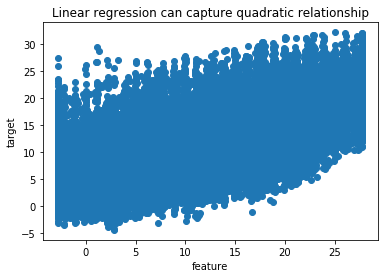

In [13]:
# fit a linear regression where target is Y & features are X
lrm = linear_model.LinearRegression()
lrm.fit(X,Y)

# predictions of the linear regression
predictions = lrm.predict(X)

# we print the estimated coefficients
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)


# we plot the estimated Y and X the relationship should be quadratic
plt.scatter(Y, predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

Appears that the model is not linear

In [28]:
#Check that the error term is zero on average
predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the medical costs model is: {}".format(np.mean(errors)))

Mean of the errors in the medical costs model is: -9.898992648452822e-14


The mean of the errors in the model is equal to zero so no impact on the model in this area

In [29]:
#Check for homoscedasticity of the error (normal distribution of the error)

from scipy.stats import bartlett
from scipy.stats import levene


bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

Bartlett test statistic value is 139.094 and p value is 4.2e-32
Levene test statistic value is 89.5222 and p value is 3.06e-21


The p values are <.05 so we reject the null that the errors are normally distributed (we do not have homoscedasticity).  The features' errors are affecting the distribution.  May be caused by outliers.

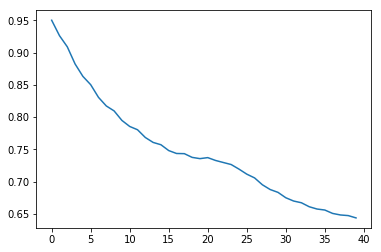

In [30]:
#Check for Multicolliniarity
from statsmodels.tsa.stattools import acf

acf_data = acf(errors)

plt.plot(acf_data[1:])
plt.show()

In [31]:
weather_clean.corr()

,temperature,humidity,windspeed,windbearing,pressure
temperature,1.000,-0.632,0.011,0.028,-0.298
humidity,-0.632,1.000,-0.234,0.002,0.041
windspeed,0.011,-0.234,1.000,0.090,-0.243
windbearing,0.028,0.002,0.090,1.000,-0.083
pressure,-0.298,0.041,-0.243,-0.083,1.000


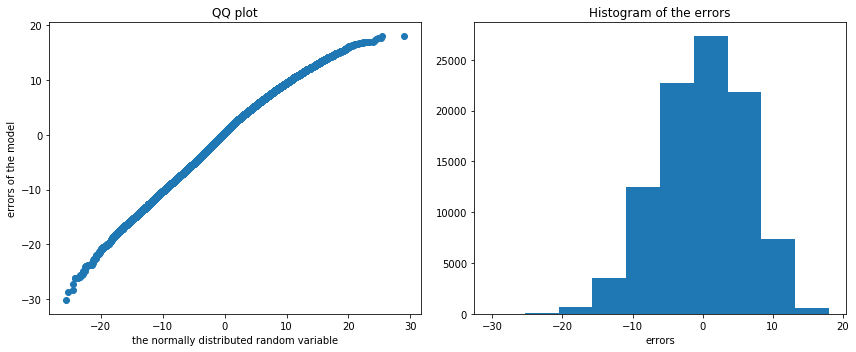

In [32]:
#Further check that the error terms are not correlated with one another
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

In [18]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

In [33]:
#Statistical check that the features are not correlated with the errors
jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

Jarque-Bera test statistics is 1316.3438861844324 and p value is 0.0
Normality test statistics is 1342.7322762784715 and p value is 2.6877623707805177e-292


The p values are <.05 so we reject the null that the errors are normally distibuted and tha the features are not correlated with one another.  